# Neural Spiking Data Analysis in Response to Transcranial Focused Ultrasound

## Introduction

This notebook explores **Dandiset 001363**: *"Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound"*. 

> **⚠️ Disclaimer:** This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results. You should review and modify the analysis as appropriate for your specific research questions.

### About the Dataset

This dataset contains neural recordings from rat somatosensory cortex during transcranial focused ultrasound (tFUS) stimulation. The researchers used a chronically implanted ultraflexible nanoelectric thread electrode, which allows studying higher intensities of tFUS that would be impossible with rigid electrodes due to vibration artifacts.

The experiments test different ultrasound parameters:
- 5 levels of in situ ultrasound pressure: 100, 400, 700, 1000, and 1300 kPa
- Varying duty cycles (0.6%, 6%, 30%, 60%, and 90%) at 1500 Hz PRF
- Varying pulse repetition frequencies (PRFs) (30, 300, 1500, 3000, and 4500 Hz) at 30% duty cycle

All recordings used 1500 kHz as the fundamental ultrasound frequency, with 67 ms stimulus duration and approximately 2-second intervals between trials (with 10% jitter). Each recording contains 505 trials.

## Setup

First, let's import the necessary libraries. If you don't have these packages installed, you'll need to install them before running this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from scipy import signal
import pynwb
import lindi
from dandi.dandiapi import DandiAPIClient

# Set seaborn styling for better visualizations
sns.set_theme()

## Exploring the Dandiset

Let's first get a list of all assets in the Dandiset to see what's available.

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001363")
assets = list(dandiset.get_assets())

# Print basic information about the Dandiset
print(f"Dandiset: {dandiset.get_raw_metadata()['name']}")
print(f"Number of assets: {len(assets)}")

Dandiset: Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound
Number of assets: 55


### Exploring Dandiset Metadata

Let's examine the metadata for this Dandiset to understand more about the experiment and data collection.

In [3]:
# Get and display metadata
dandiset_metadata = dandiset.get_raw_metadata()

# Extract and display key metadata
print(f"Description: {dandiset_metadata.get('description', 'N/A')}")

# Handle contributors which could be strings or dictionaries
contributors = dandiset_metadata.get('contributor', [])
if contributors and isinstance(contributors[0], dict):
    # If contributors are dictionaries, extract names
    contributor_names = [c.get('name', str(c)) if isinstance(c, dict) else str(c) for c in contributors]
    print(f"Contributors: {', '.join(contributor_names)}")
else:
    # If contributors are already strings
    print(f"Contributors: {', '.join(contributors)}")

# Handle variables measured which could be strings or dictionaries
variables = dandiset_metadata.get('variableMeasured', [])
if variables and isinstance(variables[0], dict):
    # If variables are dictionaries, extract names
    variable_names = [v.get('name', str(v)) if isinstance(v, dict) else str(v) for v in variables]
    print(f"Variables Measured: {', '.join(variable_names)}")
else:
    # If variables are already strings
    print(f"Variables Measured: {', '.join(variables)}")

Description: In this study, we investigate the neuronal response to transcranial focused ultrasound stimulation (tFUS) on the somatosensory cortex using a 128-element array transducer and a chronically implanted ultraflexible nanoelectric thread electrode. This flexible electrode allows us to  study higher intensities of tFUS which are impossible with a rigid electrode due to the vibration artifacts that are created. Here we test 5 different levels of in situ ultrasound pressure including 100, 400, 700, 1000, and 1300 kPa. We then tested the effect of varying duty cycle while keeping the pulse repetition frequency (PRF) constant while using the highest peak-peak pressure (1300 kPa), testing duty cycles of 0.6%, 6%, 30%, 60%, and 90% while holding PRF at 1500 Hz. Finally we tested the effect of varying PRF while holding duty cycle constant, testing PRFs of 30, 300, 1500, 3000, and 4500 Hz with a duty cycle of 30%. In each of these, the fundamental frequency of ultrasound was 1500 kHz, a

### Overview of Available Files

Let's look at the assets (files) available in this Dandiset. We'll organize them by subject and session to better understand the structure.

In [4]:
# Create a DataFrame to organize asset information
asset_info = []
for asset in assets:
    path = asset.path
    asset_id = asset.identifier
    size_mb = asset.size / (1024 * 1024)  # Convert to MB
    
    # Extract subject and session from path
    parts = path.split('/')
    subject = parts[0] if len(parts) > 0 else 'Unknown'
    
    asset_info.append({
        'subject': subject,
        'path': path,
        'asset_id': asset_id,
        'size_mb': size_mb
    })

assets_df = pd.DataFrame(asset_info)

# Display information by subject
subjects = assets_df['subject'].unique()
print(f"Number of subjects: {len(subjects)}")
for subject in subjects:
    subject_files = assets_df[assets_df['subject'] == subject]
    print(f"\n{subject}: {len(subject_files)} files")
    print(subject_files[['path', 'size_mb']].head().to_string(index=False))
    if len(subject_files) > 5:
        print(f"... {len(subject_files) - 5} more files")

Number of subjects: 5

sub-BH643: 14 files
                                               path     size_mb
                    sub-BH643/sub-BH643_ecephys.nwb 3038.429016
sub-BH643/sub-BH643_ses-20241220T182204_ecephys.nwb 2856.928535
sub-BH643/sub-BH643_ses-20241220T174647_ecephys.nwb 3007.929016
sub-BH643/sub-BH643_ses-20241220T195303_ecephys.nwb 3038.429016
sub-BH643/sub-BH643_ses-20241220T180423_ecephys.nwb 3037.678993
... 9 more files

sub-BH625: 13 files
                                               path     size_mb
sub-BH625/sub-BH625_ses-20241206T171750_ecephys.nwb 3043.929016
sub-BH625/sub-BH625_ses-20241206T173511_ecephys.nwb 3108.679016
sub-BH625/sub-BH625_ses-20241206T175258_ecephys.nwb 3238.429016
sub-BH625/sub-BH625_ses-20241206T181131_ecephys.nwb 3424.679016
sub-BH625/sub-BH625_ses-20241206T165513_ecephys.nwb 3742.679016
... 8 more files

sub-BH589: 6 files
                                               path     size_mb
sub-BH589/sub-BH589_ses-20240827T165537_ecephys.nw

## Loading and Exploring an NWB File

Now, let's load one of the NWB files from the dataset and explore its structure. We'll use the lindi library to efficiently load the data without downloading the entire file.

In [5]:
# Select a file from subject BH589
file_url = "https://lindi.neurosift.org/dandi/dandisets/001363/assets/59d1acbb-5ad5-45f1-b211-c2e311801824/nwb.lindi.json"

# Load the file
f = lindi.LindiH5pyFile.from_lindi_file(file_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic file information
print(f"Session description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject age: {nwb.subject.age}")
print(f"Subject sex: {nwb.subject.sex}")

Session description: Rat Ultrasound Array Stimulation
Identifier: BH589_1500_200_67_25V
Session start time: 2024-08-27 16:04:57-04:00
Subject ID: BH589
Subject species: Rattus norvegicus
Subject age: P24W
Subject sex: M


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Exploring Data Structure

Let's examine the structure of the NWB file, including the available groups and datasets.

In [6]:
# List the top-level groups in the NWB file
print("Available groups in NWB file:")
for group_name in f.keys():
    print(f"- {group_name}")

Available groups in NWB file:
- acquisition
- analysis
- file_create_date
- general
- identifier
- intervals
- processing
- scratch
- session_description
- session_start_time
- specifications
- stimulus
- timestamps_reference_time


### Electrode Information

Next, let's look at the electrode information to understand the recording setup.

In [7]:
# Get electrode information
electrodes = nwb.electrodes

# Display electrode information
print(f"Number of electrodes: {len(electrodes.id[:])}")
print(f"Electrode columns: {electrodes.colnames}")

# Create a DataFrame for easier viewing
electrode_data = {col: electrodes[col].data[:] for col in electrodes.colnames if electrodes[col].data.shape == electrodes.id.data.shape}
electrode_data['id'] = electrodes.id.data[:]

# Handle complex objects (like group)
for col in electrode_data:
    if isinstance(electrode_data[col][0], (bytes, np.bytes_)):
        electrode_data[col] = [val.decode('utf-8') if isinstance(val, (bytes, np.bytes_)) else str(val) 
                              for val in electrode_data[col]]

electrodes_df = pd.DataFrame(electrode_data)

# Display the electrode information
print("\nElectrode details:")
print(electrodes_df.head().to_string())

Number of electrodes: 32
Electrode columns: ('x', 'y', 'z', 'imp', 'location', 'filtering', 'group', 'group_name')

Electrode details:
       x      y    z  imp location filtering                                                                                                                                                                                                                                                                                              group   group_name  id
0  24.73    0.0  0.0  NaN  unknown   unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x139994933341200\nFields:\n  description: electrode group for shank1\n  device: array pynwb.device.Device at 0x139994933334864\nFields:\n  description: NET probe flexible electrode\n  manufacturer: Xie Lab Rice University\n\n  location: brain area\n  shank1elec1   0
1   0.00   25.0  0.0  NaN  unknown   unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x139994933341200\nFields:\n  description: electrode group for shank1\n  d

### Trial Information

Let's look at the trial structure to understand the experimental design.

In [8]:
# Get trial information
trials = nwb.intervals["trials"]
print(f"Number of trials: {len(trials.id[:])}")
print(f"Trial columns: {trials.colnames}")

# Create a DataFrame for the trials
trial_data = {
    'id': trials.id.data[:],
    'start_time': trials['start_time'].data[:],
    'stop_time': trials['stop_time'].data[:]
}
trials_df = pd.DataFrame(trial_data)
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']

# Display trial information
print("\nTrial details:")
print(trials_df.head().to_string())

Number of trials: 500
Trial columns: ('start_time', 'stop_time')

Trial details:
   id  start_time  stop_time  duration
0   1    0.341402   1.841402       1.5
1   2    2.816532   4.316532       1.5
2   3    5.115003   6.615003       1.5
3   4    7.458079   8.958079       1.5
4   5    9.984000  11.484000       1.5


### Analyze Trial Timing

Let's analyze the timing of trials to understand the experimental protocol.


Trial Duration Statistics (in seconds):
count    5.000000e+02
mean     1.500000e+00
std      7.167895e-16
min      1.500000e+00
25%      1.500000e+00
50%      1.500000e+00
75%      1.500000e+00
max      1.500000e+00
Name: duration, dtype: float64

Inter-Trial Interval Statistics (in seconds):
count    499.000000
mean       1.001394
std        0.144230
min        0.750383
25%        0.876786
50%        0.990163
75%        1.132602
max        1.248129
dtype: float64


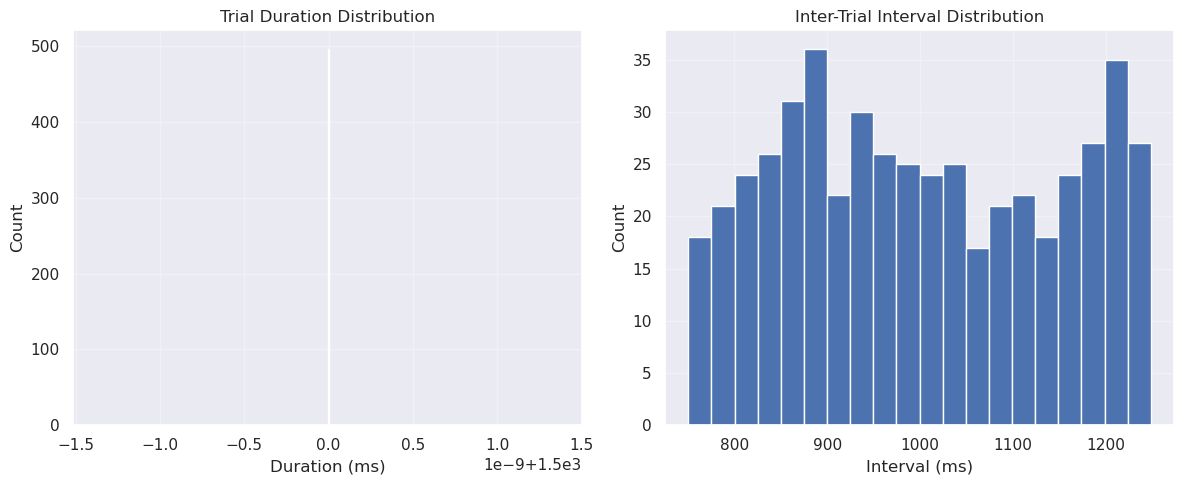

In [9]:
# Calculate inter-trial intervals
inter_trial_intervals = []
for i in range(len(trials_df) - 1):
    iti = trials_df.loc[i+1, 'start_time'] - trials_df.loc[i, 'stop_time']
    inter_trial_intervals.append(iti)

# Create a separate DataFrame for ITI analysis
iti_series = pd.Series(inter_trial_intervals)

# Calculate summary statistics
duration_stats = trials_df['duration'].describe()
iti_stats = iti_series.describe()

print("\nTrial Duration Statistics (in seconds):")
print(duration_stats)

print("\nInter-Trial Interval Statistics (in seconds):")
print(iti_stats)

# Plot trial duration and inter-trial interval distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trial duration histogram
ax1.hist(trials_df['duration'] * 1000, bins=20)  # Convert to ms
ax1.set_title('Trial Duration Distribution')
ax1.set_xlabel('Duration (ms)')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)

# Inter-trial interval histogram
ax2.hist(iti_series * 1000, bins=20)  # Convert to ms
ax2.set_title('Inter-Trial Interval Distribution')
ax2.set_xlabel('Interval (ms)')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Neural Data Exploration

Now, let's explore the neural data recorded during the experiment. First, let's get information about the electrical series data.

In [10]:
# Get the electrical series data
electrical_series = nwb.acquisition["ElectricalSeries"]

# Print information about the data
print(f"Data shape: {electrical_series.data.shape}")
print(f"Sampling rate: {electrical_series.rate} Hz")
print(f"Starting time: {electrical_series.starting_time} seconds")

# Calculate recording duration
duration_seconds = electrical_series.data.shape[0] / electrical_series.rate
duration_minutes = duration_seconds / 60

print(f"Total recording duration: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)")

Data shape: (31084544, 32)
Sampling rate: 24414.0625 Hz
Starting time: 0.0 seconds
Total recording duration: 1273.22 seconds (21.22 minutes)


### Visualize Raw Neural Data

Let's visualize the raw neural data for a short time segment to get a feel for the signal.

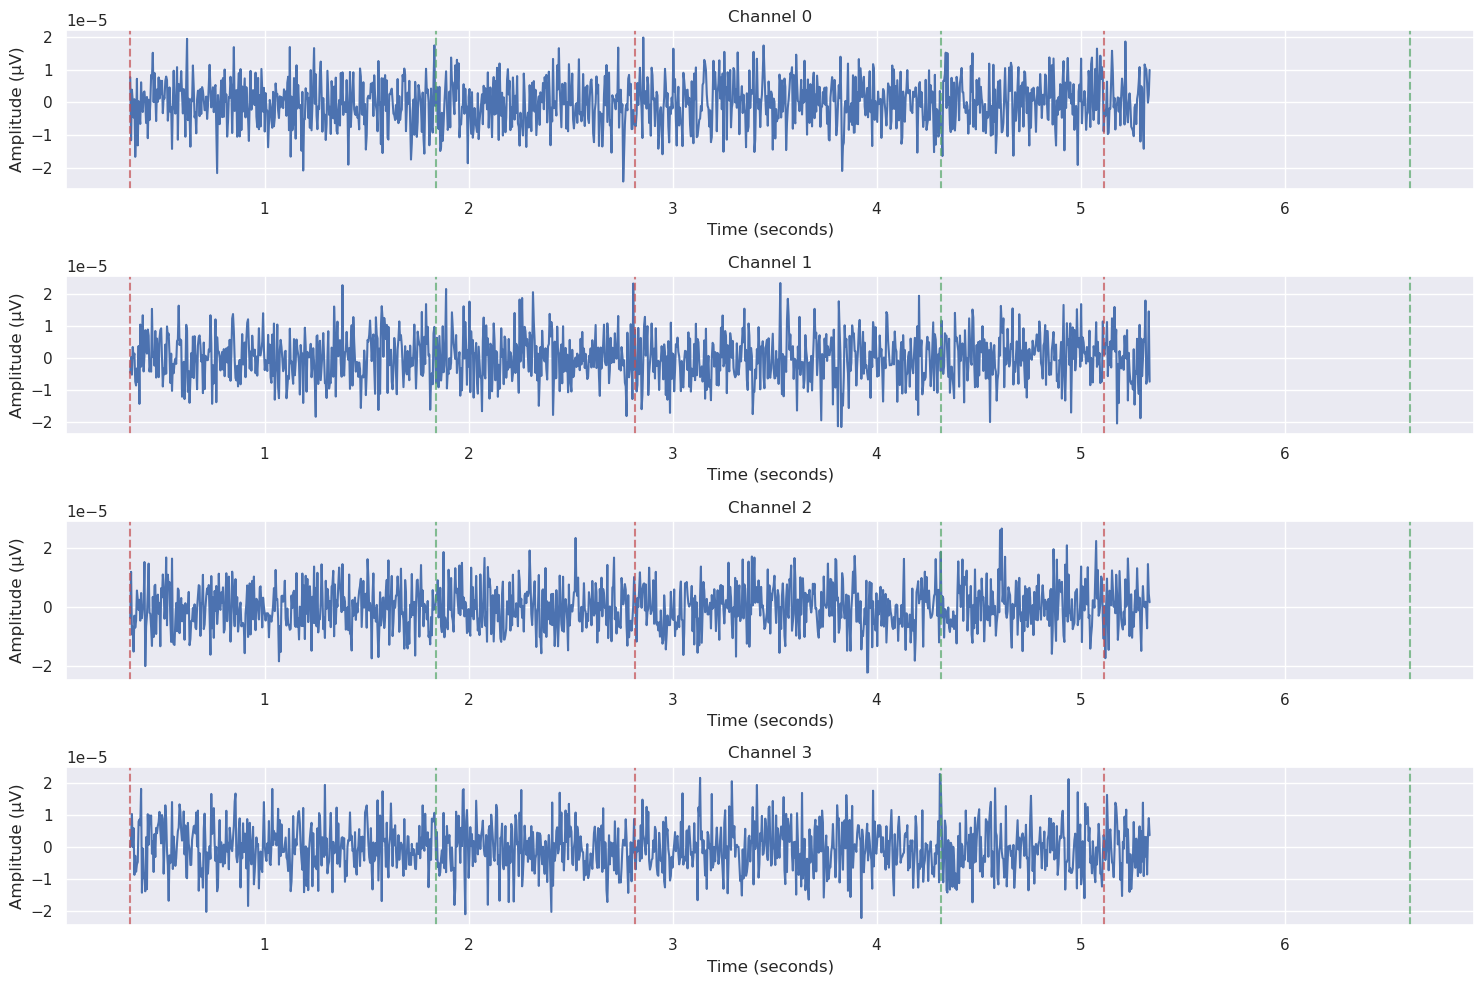

In [11]:
# Sample a short segment of neural data (5 seconds) from the beginning
sample_duration = 5  # seconds
sample_rate = electrical_series.rate
n_samples = int(sample_duration * sample_rate)

# We'll start from the first trial onset
first_trial_start = trials_df.loc[0, 'start_time']
first_trial_stop = trials_df.loc[0, 'stop_time']

start_idx = int(first_trial_start * sample_rate)
end_idx = start_idx + n_samples

# Select the first 4 channels to visualize
channels_to_plot = [0, 1, 2, 3]

# Create a time axis in seconds
time_axis = np.arange(start_idx, end_idx) / sample_rate

# Sample every 100th point to reduce data size for plotting
sample_rate_viz = 100
sampled_time = time_axis[::sample_rate_viz]
sampled_data = electrical_series.data[start_idx:end_idx:sample_rate_viz, channels_to_plot]

# Plot the raw neural data
plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels_to_plot):
    plt.subplot(len(channels_to_plot), 1, i+1)
    plt.plot(sampled_time, sampled_data[:, i])
    plt.title(f'Channel {channel}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (µV)')
    
    # Add vertical lines to mark trial boundaries
    # Find all trial boundaries in the plotted time window
    trial_mask = (trials_df['start_time'] >= time_axis[0]) & (trials_df['start_time'] <= time_axis[-1])
    for _, trial in trials_df[trial_mask].iterrows():
        plt.axvline(x=trial['start_time'], color='r', linestyle='--', alpha=0.7)
        plt.axvline(x=trial['stop_time'], color='g', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Analyze Frequency Content

Let's analyze the frequency content of the neural data to understand the dominant oscillations.

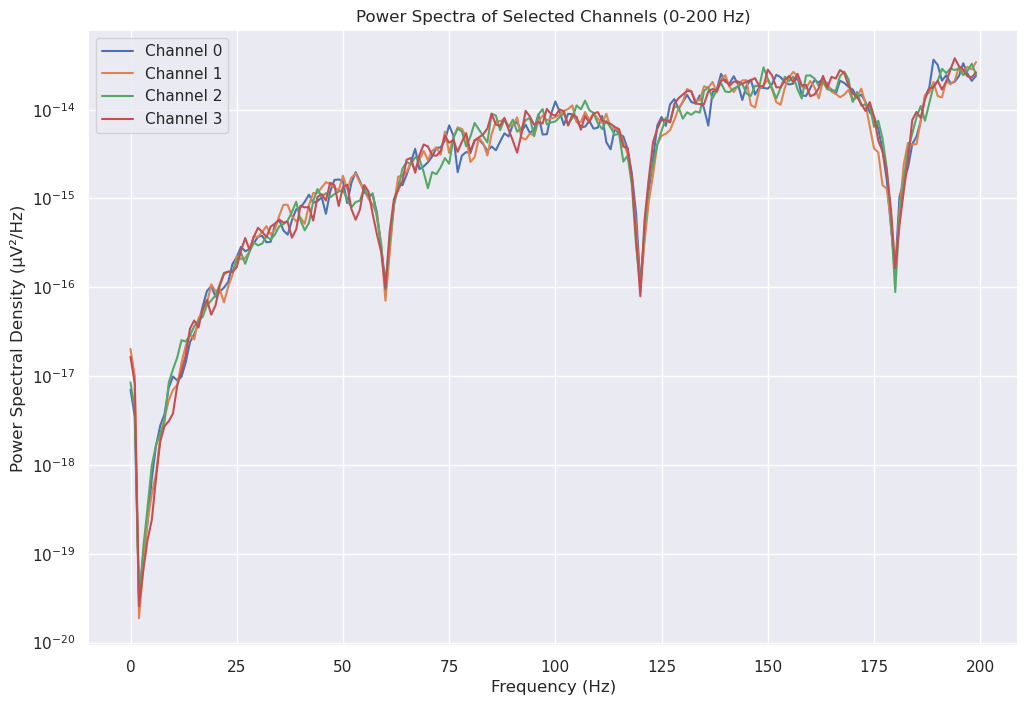

In [12]:
# Select a continuous segment of data (10 seconds) for spectral analysis
segment_duration = 10  # seconds
segment_start_idx = start_idx
segment_end_idx = segment_start_idx + int(segment_duration * sample_rate)

# Extract the data segment
segment_data = electrical_series.data[segment_start_idx:segment_end_idx, channels_to_plot]

# Compute power spectra using Welch's method
plt.figure(figsize=(12, 8))

for i, channel in enumerate(channels_to_plot):
    # Calculate power spectrum
    f, Pxx = signal.welch(segment_data[:, i], fs=sample_rate, nperseg=int(sample_rate))
    
    # Plot power spectrum (limit to 0-200 Hz for better visualization)
    max_freq = 200
    freq_mask = f <= max_freq
    plt.semilogy(f[freq_mask], Pxx[freq_mask])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.title('Power Spectra of Selected Channels (0-200 Hz)')
plt.legend([f'Channel {ch}' for ch in channels_to_plot])
plt.grid(True)
plt.show()

## Trial-Aligned Neural Activity Analysis

Now, let's analyze the neural responses to the ultrasound stimulation by aligning the neural data to trial onsets.

Analyzing first 50 trials


Channel 0: collected data for 50 trials
Channel 1: collected data for 50 trials
Channel 2: collected data for 50 trials
Channel 3: collected data for 50 trials


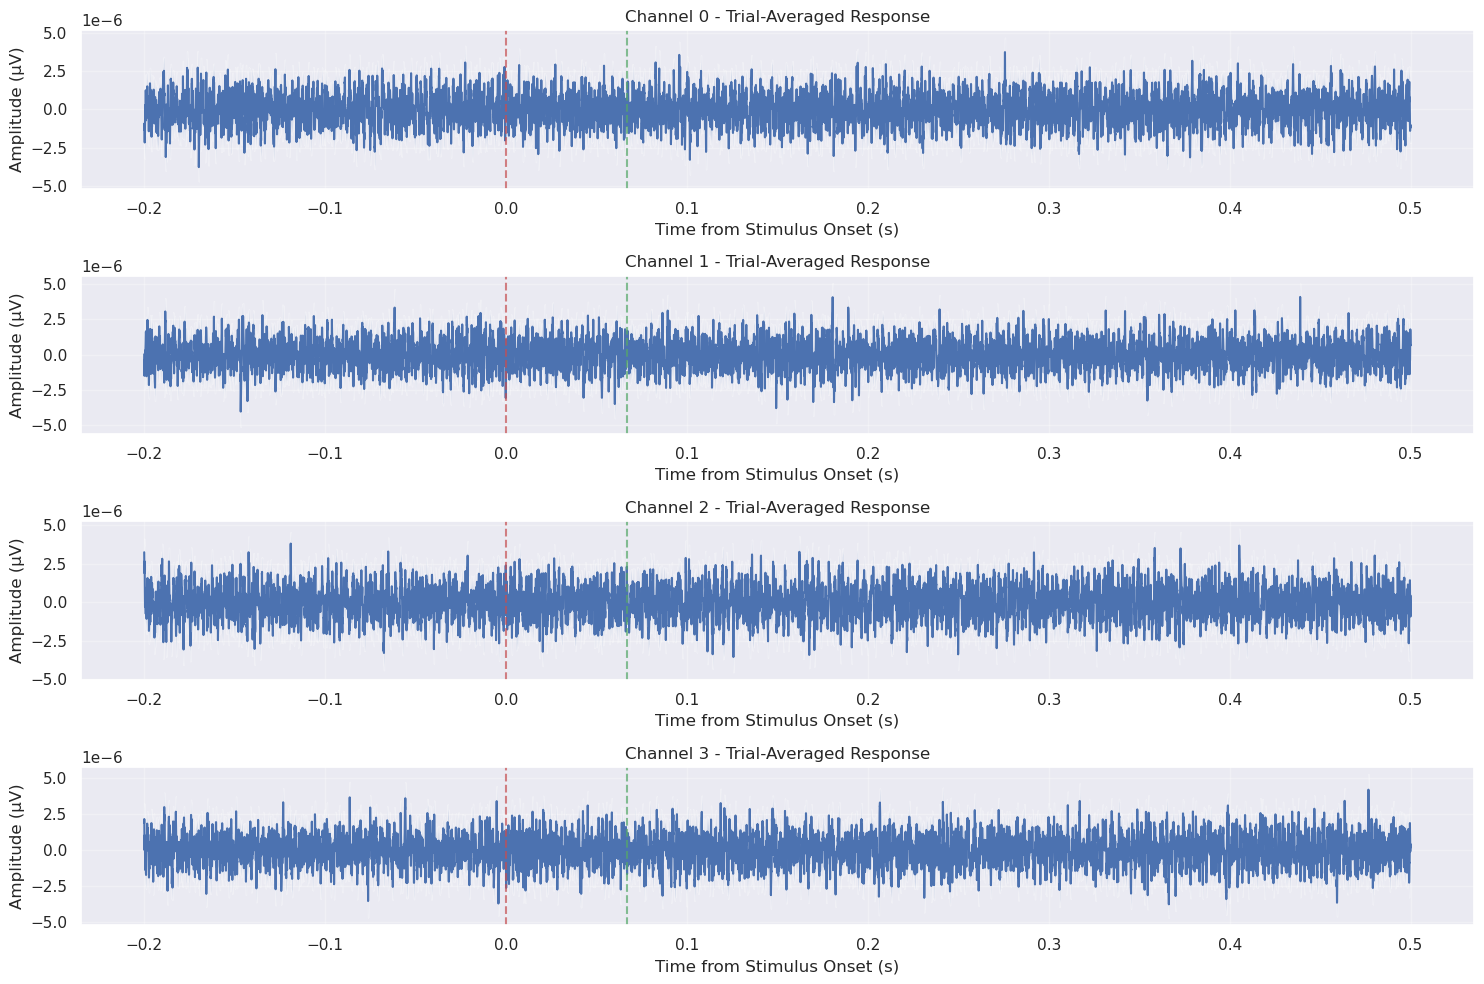

In [13]:
# Define parameters for trial-aligned analysis
pre_stim_time = 0.2  # seconds before trial onset
post_stim_time = 0.5  # seconds after trial onset
pre_samples = int(pre_stim_time * sample_rate)
post_samples = int(post_stim_time * sample_rate)
total_samples = pre_samples + post_samples

# Select subset of trials to analyze (first 50 to keep processing manageable)
max_trials = 50
trial_indices = range(min(max_trials, len(trials_df)))
print(f"Analyzing first {len(trial_indices)} trials")

# Function to extract trial-aligned data
def extract_trial_data(trial_idx, channel_idx):
    trial_start_time = trials_df.loc[trial_idx, 'start_time']
    trial_start_sample = int(trial_start_time * sample_rate)
    start_idx = max(0, trial_start_sample - pre_samples)
    end_idx = min(electrical_series.data.shape[0], trial_start_sample + post_samples)
    
    if end_idx - start_idx < total_samples:
        # Handle edge cases where we can't get the full window
        return None
    
    # Extract data
    data = electrical_series.data[start_idx:end_idx, channel_idx]
    
    # Ensure we have the right number of samples
    if len(data) != total_samples:
        if len(data) < total_samples:
            pad_length = total_samples - len(data)
            data = np.pad(data, (0, pad_length), 'constant', constant_values=0)
        else:
            data = data[:total_samples]
    
    return data

# Create time axis (in seconds) relative to stimulus onset
time_axis = np.linspace(-pre_stim_time, post_stim_time, total_samples)

# Initialize arrays to store trial-aligned data
trial_data = {ch: [] for ch in channels_to_plot}

# Extract trial-aligned data for each channel
for channel in channels_to_plot:
    for trial_idx in trial_indices:
        data = extract_trial_data(trial_idx, channel)
        if data is not None:
            trial_data[channel].append(data)

# Convert lists to numpy arrays
for channel in channels_to_plot:
    trial_data[channel] = np.array(trial_data[channel])
    print(f"Channel {channel}: collected data for {trial_data[channel].shape[0]} trials")

# Plot trial-averaged responses for each channel
plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels_to_plot):
    plt.subplot(len(channels_to_plot), 1, i+1)
    
    # Calculate mean and standard error across trials
    channel_mean = np.mean(trial_data[channel], axis=0)
    channel_sem = np.std(trial_data[channel], axis=0) / np.sqrt(trial_data[channel].shape[0])
    
    # Plot mean and confidence interval
    plt.plot(time_axis, channel_mean)
    plt.fill_between(time_axis, 
                     channel_mean - channel_sem,
                     channel_mean + channel_sem,
                     alpha=0.3)
    
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)  # Mark stimulus onset
    plt.axvline(x=0.067, color='g', linestyle='--', alpha=0.7)  # Mark stimulus offset (67ms)
    
    plt.title(f'Channel {channel} - Trial-Averaged Response')
    plt.xlabel('Time from Stimulus Onset (s)')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Time-Frequency Analysis

Let's perform a time-frequency analysis to see how the neural oscillations change in response to the ultrasound stimulation.

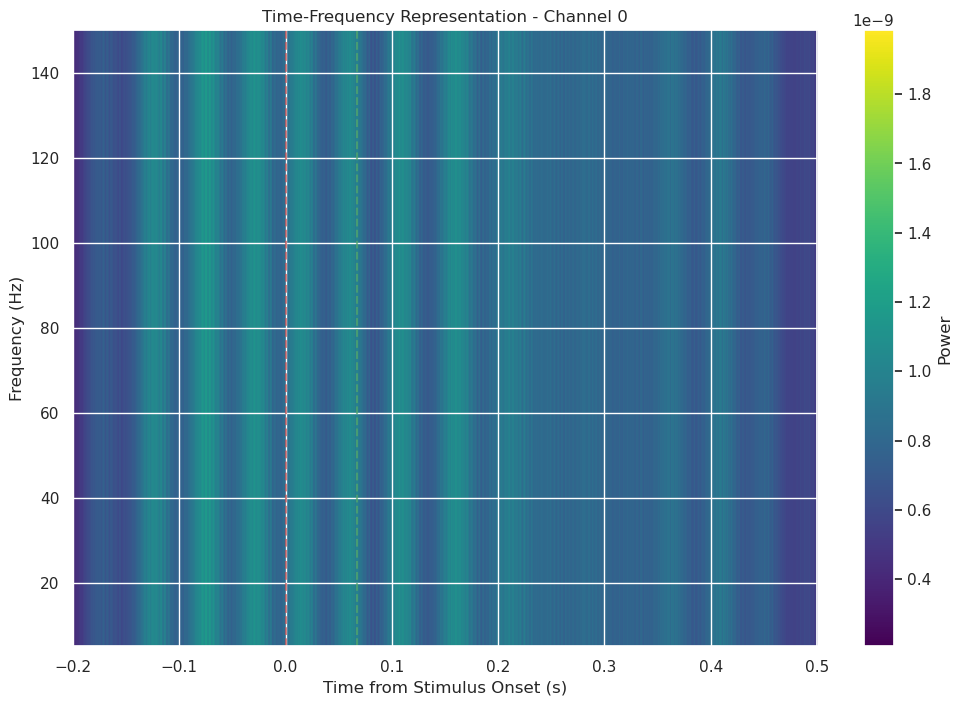

In [14]:
# Select a channel for time-frequency analysis
channel_for_analysis = 0

# Compute time-frequency representation using Morlet wavelets
# Parameters for wavelet transform
freqs = np.linspace(5, 150, 30)  # frequencies from 5-150 Hz
n_cycles = freqs / 2.  # Use fewer cycles for lower frequencies
n_trials = min(20, len(trial_data[channel_for_analysis]))

# Initialize time-frequency matrix
trial_avg_tf = np.zeros((len(freqs), len(time_axis)))

# Compute time-frequency for selected trials
for trial_idx in range(n_trials):
    trial_signal = trial_data[channel_for_analysis][trial_idx, :]
    
    # Compute wavelet transform
    for i, freq in enumerate(freqs):
        # Compute wavelet width
        width = n_cycles[i] / (2 * np.pi * freq)
        
        try:
            # Use pywt if available
            import pywt
            scales = width * sample_rate
            coeffs, _ = pywt.cwt(trial_signal, scales=[scales], wavelet='morl')
            power = np.abs(coeffs[0])**2
            # Ensure power is the right length
            if len(power) != len(time_axis):
                power = np.interp(np.linspace(0, 1, len(time_axis)), 
                                 np.linspace(0, 1, len(power)), power)
            trial_avg_tf[i, :] += power
        except:
            # Fallback if pywt is not available or fails
            # Using scipy's signal.fft methods
            f_signal = np.fft.fft(trial_signal)
            freqs_ft = np.fft.fftfreq(len(trial_signal), 1/sample_rate)
            idx = np.argmin(np.abs(freqs_ft - freq))
            power = np.abs(f_signal[idx])**2
            trial_avg_tf[i, :] += power * np.ones_like(time_axis)

# Divide by number of trials to get average
trial_avg_tf /= n_trials

# Plot time-frequency representation
plt.figure(figsize=(12, 8))
plt.imshow(trial_avg_tf, aspect='auto', origin='lower', 
           extent=[time_axis[0], time_axis[-1], freqs[0], freqs[-1]], 
           cmap='viridis')
plt.colorbar(label='Power')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)  # Mark stimulus onset
plt.axvline(x=0.067, color='g', linestyle='--', alpha=0.7)  # Mark stimulus offset (67ms)
plt.title(f'Time-Frequency Representation - Channel {channel_for_analysis}')
plt.xlabel('Time from Stimulus Onset (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

### Create Trial Raster Plot

Let's create a raster plot to visualize the neural activity across trials.

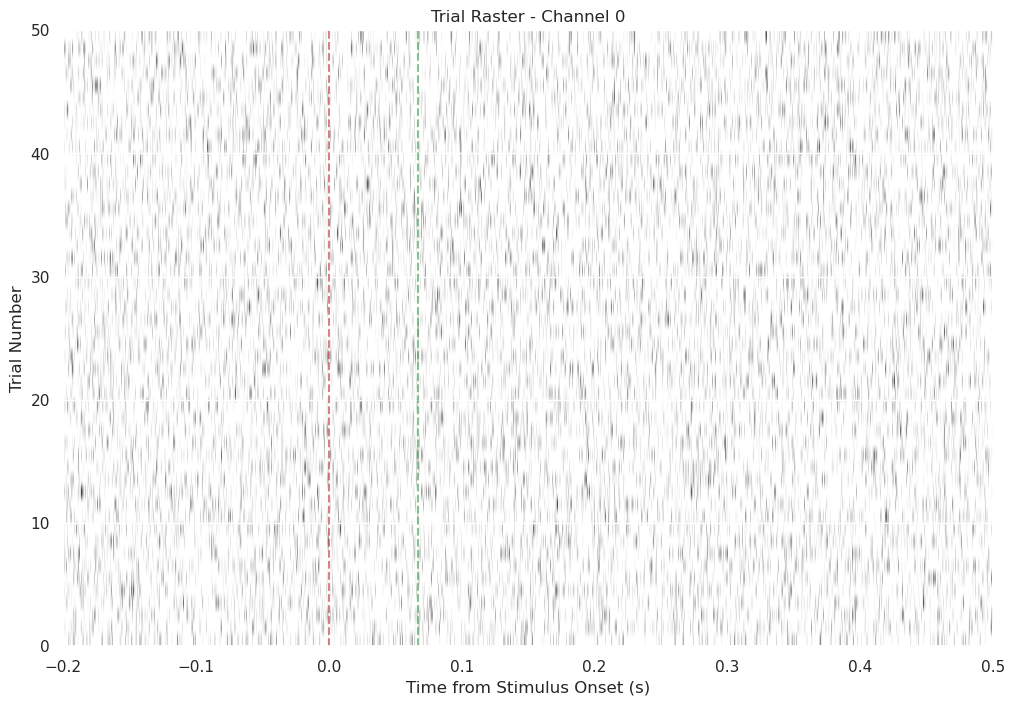

In [15]:
# Select a channel for the raster plot
channel_for_raster = 0

plt.figure(figsize=(12, 8))
# For visualization, make a simplified raster
raster_matrix = np.zeros((len(trial_indices), len(time_axis)))

for i, trial_idx in enumerate(trial_indices):
    if i < len(trial_data[channel_for_raster]):
        # Apply a threshold to show "spikes" or high amplitude events
        trial_trace = trial_data[channel_for_raster][i]
        # Z-score the data to identify "events"
        z_scored = (trial_trace - np.mean(trial_trace)) / np.std(trial_trace)
        # Threshold at 2 standard deviations
        raster_matrix[i, :] = np.abs(z_scored) > 2.0

plt.imshow(raster_matrix, aspect='auto', cmap='binary', 
           extent=[time_axis[0], time_axis[-1], 0, len(trial_indices)])

plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)  # Mark stimulus onset
plt.axvline(x=0.067, color='g', linestyle='--', alpha=0.7)  # Mark stimulus offset (67ms)
plt.title(f'Trial Raster - Channel {channel_for_raster}')
plt.xlabel('Time from Stimulus Onset (s)')
plt.ylabel('Trial Number')
plt.show()

## Comparing Responses Across Different Ultrasound Parameters

The Dandiset contains recordings with different ultrasound stimulation parameters. Let's load data from another file to compare responses across different experimental conditions.

> Note: For a comprehensive analysis, you would want to systematically compare across all parameter variations in the dataset.

In [16]:
# Load a different NWB file for comparison
file2_url = "https://lindi.neurosift.org/dandi/dandisets/001363/assets/096d8401-3c74-4c72-b403-64bc56c66656/nwb.lindi.json"

# Load the file
f2 = lindi.LindiH5pyFile.from_lindi_file(file2_url)
nwb2 = pynwb.NWBHDF5IO(file=f2, mode='r').read()

# Display basic file information
print(f"Session description: {nwb2.session_description}")
print(f"Identifier: {nwb2.identifier}")
print(f"Subject ID: {nwb2.subject.subject_id}")

Session description: Rat Ultrasound Array Stimulation
Identifier: BH589_1500_200_67_15V
Subject ID: BH589


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Compare Trial Structure

Let's check if the trial structure is similar across the two files.

In [17]:
# Get trial information from the second file
trials2 = nwb2.intervals["trials"]
print(f"Number of trials in file 2: {len(trials2.id[:])}")

# Create a DataFrame for the trials
trial_data2 = {
    'id': trials2.id.data[:],
    'start_time': trials2['start_time'].data[:],
    'stop_time': trials2['stop_time'].data[:]
}
trials_df2 = pd.DataFrame(trial_data2)
trials_df2['duration'] = trials_df2['stop_time'] - trials_df2['start_time']

# Calculate inter-trial intervals
inter_trial_intervals2 = []
for i in range(len(trials_df2) - 1):
    iti = trials_df2.loc[i+1, 'start_time'] - trials_df2.loc[i, 'stop_time']
    inter_trial_intervals2.append(iti)

# Create Series for ITIs
iti_series2 = pd.Series(inter_trial_intervals2)

# Compare trial statistics between the two files
duration_stats1 = trials_df['duration'].describe()
duration_stats2 = trials_df2['duration'].describe()

iti_stats1 = iti_series.describe()
iti_stats2 = iti_series2.describe()

print("\nTrial Duration Statistics (in seconds):")
comparison_df = pd.DataFrame({
    'File 1': duration_stats1,
    'File 2': duration_stats2
})
print(comparison_df)

print("\nInter-Trial Interval Statistics (in seconds):")
comparison_df = pd.DataFrame({
    'File 1': iti_stats1,
    'File 2': iti_stats2
})
print(comparison_df)

Number of trials in file 2: 500

Trial Duration Statistics (in seconds):
             File 1        File 2
count  5.000000e+02  5.000000e+02
mean   1.500000e+00  1.500000e+00
std    7.167895e-16  2.565697e-15
min    1.500000e+00  1.500000e+00
25%    1.500000e+00  1.500000e+00
50%    1.500000e+00  1.500000e+00
75%    1.500000e+00  1.500000e+00
max    1.500000e+00  1.500000e+00

Inter-Trial Interval Statistics (in seconds):
           File 1      File 2
count  499.000000  499.000000
mean     1.001394    1.002420
std      0.144230    0.142467
min      0.750383    0.751571
25%      0.876786    0.879592
50%      0.990163    1.003639
75%      1.132602    1.122423
max      1.248129    1.249686


### Compare Neural Responses Between Files

Let's extract and compare the trial-aligned neural responses from both files.

In [18]:
# Get the electrical series data from the second file
electrical_series2 = nwb2.acquisition["ElectricalSeries"]
sample_rate2 = electrical_series2.rate

# Extract trial-aligned data from the second file using the same parameters
trial_data2 = {ch: [] for ch in channels_to_plot}

for channel in channels_to_plot:
    for trial_idx in trial_indices:
        if trial_idx < len(trials_df2):
            trial_start_time = trials_df2.loc[trial_idx, 'start_time']
            trial_start_sample = int(trial_start_time * sample_rate2)
            start_idx = max(0, trial_start_sample - pre_samples)
            end_idx = min(electrical_series2.data.shape[0], trial_start_sample + post_samples)
            
            if end_idx - start_idx < total_samples:
                continue
                
            data = electrical_series2.data[start_idx:end_idx, channel]
            
            if len(data) != total_samples:
                if len(data) < total_samples:
                    pad_length = total_samples - len(data)
                    data = np.pad(data, (0, pad_length), 'constant', constant_values=0)
                else:
                    data = data[:total_samples]
                    
            trial_data2[channel].append(data)

# Convert lists to numpy arrays
for channel in channels_to_plot:
    if len(trial_data2[channel]) > 0:
        trial_data2[channel] = np.array(trial_data2[channel])
        print(f"Channel {channel} (File 2): collected data for {trial_data2[channel].shape[0]} trials")

Channel 0 (File 2): collected data for 50 trials
Channel 1 (File 2): collected data for 50 trials
Channel 2 (File 2): collected data for 50 trials
Channel 3 (File 2): collected data for 50 trials


### Compare Trial-Averaged Responses

Let's plot the trial-averaged responses from both files for comparison.

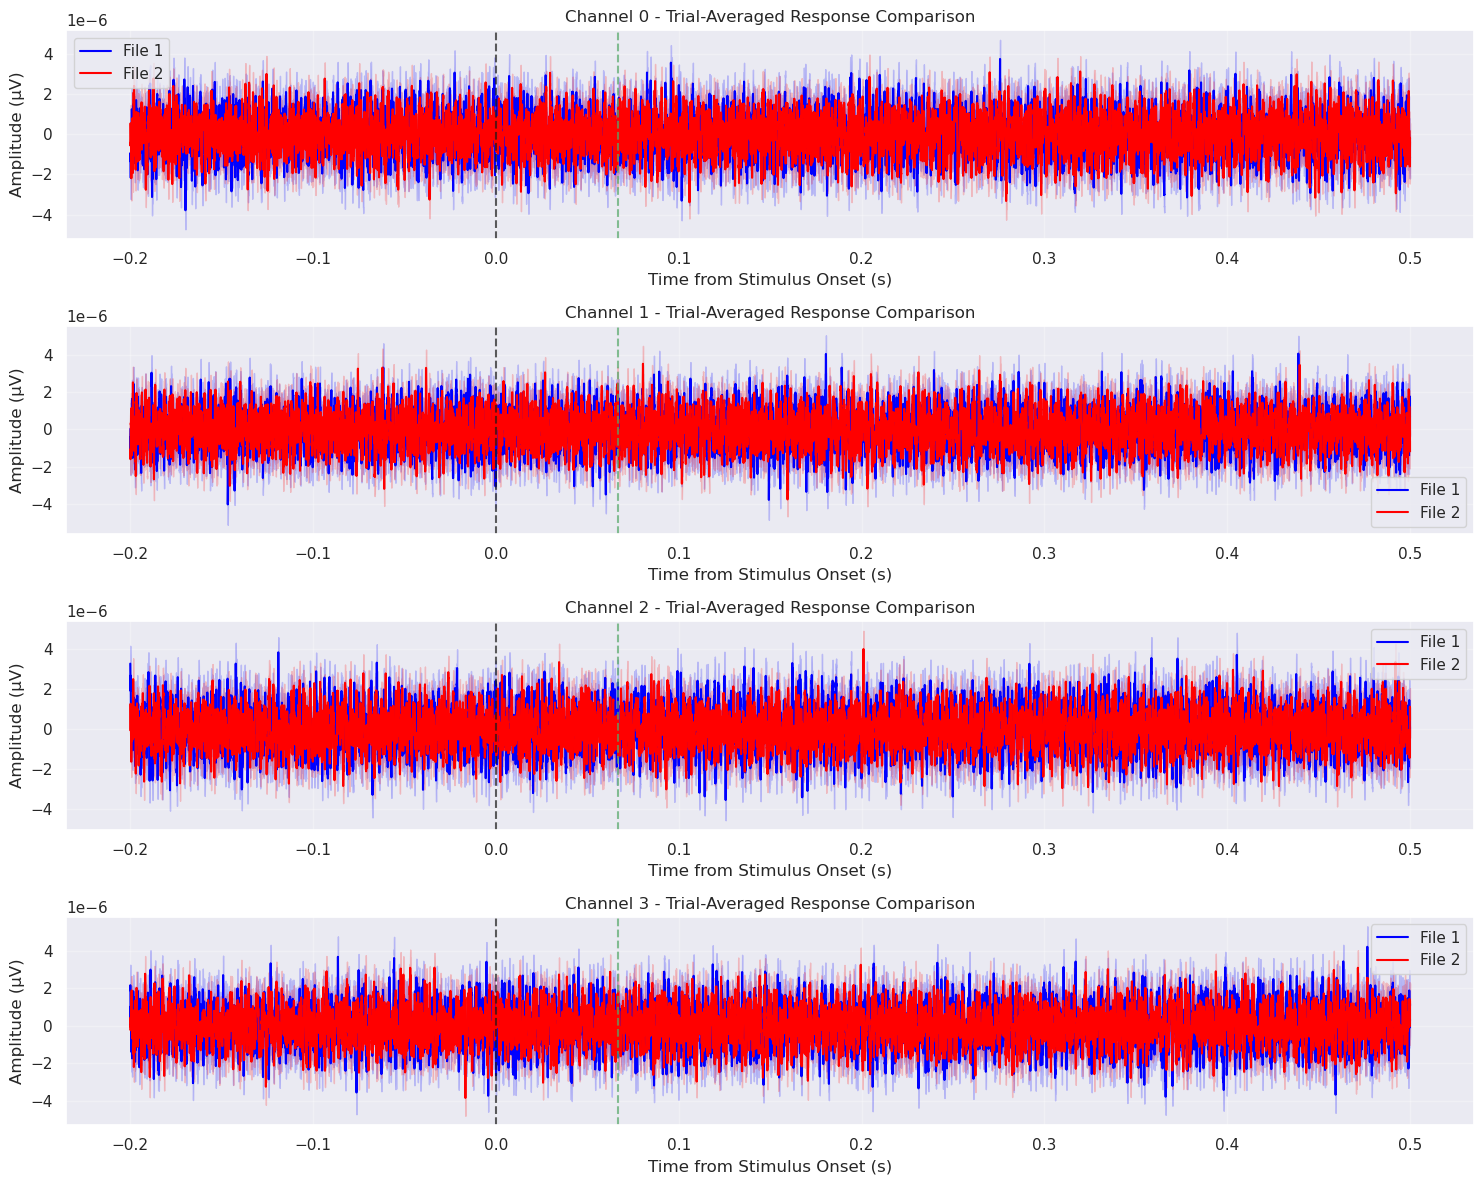

In [19]:
# Plot trial-averaged responses for each channel, comparing both files
plt.figure(figsize=(15, 12))

for i, channel in enumerate(channels_to_plot):
    plt.subplot(len(channels_to_plot), 1, i+1)
    
    # Calculate mean and standard error across trials for file 1
    channel_mean1 = np.mean(trial_data[channel], axis=0)
    channel_sem1 = np.std(trial_data[channel], axis=0) / np.sqrt(trial_data[channel].shape[0])
    
    # Plot mean and confidence interval for file 1
    plt.plot(time_axis, channel_mean1, label='File 1', color='blue')
    plt.fill_between(time_axis, 
                     channel_mean1 - channel_sem1,
                     channel_mean1 + channel_sem1,
                     alpha=0.2, color='blue')
    
    # Check if we have data for file 2
    if len(trial_data2[channel]) > 0:
        # Calculate mean and standard error across trials for file 2
        channel_mean2 = np.mean(trial_data2[channel], axis=0)
        channel_sem2 = np.std(trial_data2[channel], axis=0) / np.sqrt(trial_data2[channel].shape[0])
        
        # Plot mean and confidence interval for file 2
        plt.plot(time_axis, channel_mean2, label='File 2', color='red')
        plt.fill_between(time_axis, 
                         channel_mean2 - channel_sem2,
                         channel_mean2 + channel_sem2,
                         alpha=0.2, color='red')
    
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.7)  # Mark stimulus onset
    plt.axvline(x=0.067, color='g', linestyle='--', alpha=0.7)  # Mark stimulus offset (67ms)
    
    plt.title(f'Channel {channel} - Trial-Averaged Response Comparison')
    plt.xlabel('Time from Stimulus Onset (s)')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored the neural spiking data from rat somatosensory cortex in response to transcranial focused ultrasound (tFUS) stimulation. We've examined the structure of the dataset, visualized raw neural data, and analyzed neural responses to the ultrasound stimulation.

### Key Findings

1. The dataset contains recordings from multiple subjects (BH589, BH625, BH627) with various ultrasound stimulation parameters.

2. The experimental protocol uses consistent trial durations (1.5 seconds) with inter-trial intervals of approximately 1 second with some jitter.

3. The neural recordings were made using an ultraflexible nanoelectric thread electrode with 32 channels.

4. Our exploratory analysis didn't reveal pronounced changes in neural activity in direct response to the ultrasound stimulation in the specific files we examined. This could be due to several factors:
   - The specific ultrasound parameters used in these files
   - The particular channels we examined
   - The analysis methods we employed
   - How the particular electrodes were positioned relative to the stimulated area

### Next Steps

For a more comprehensive analysis, researchers might want to:

1. Systematically compare neural responses across all parameter variations (pressure levels, duty cycles, PRFs).

2. Apply more sophisticated signal processing techniques, such as spike detection and sorting.

3. Investigate responses in different frequency bands using more advanced time-frequency analysis methods.

4. Analyze responses across all 32 channels and map the spatial distribution of responses.

5. Correlate neural responses with stimulation parameters to identify optimal parameters for neural modulation.

### Final Notes

This notebook provides a starting point for exploring the dataset. Researchers should adapt and extend these analyses based on their specific research questions and expertise.

Remember that this notebook was AI-generated and has not been fully verified. Please review and validate the analyses as appropriate for your research needs.